# Assignment 2: Milestone I Natural Language Processing
## Task 2&3
#### Student Name: Zhen Qian
#### Student ID: s3888611

Date: 03/10/2021

Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used: please include all the libraries you used in your assignment, e.g.,:
* pandas
* re
* numpy
* sklearn
* numpy
* gensim
* pandas
* os

## Introduction
Build feature vectors and predict classifications.


## Importing libraries 

In [1]:
# Code to import libraries as you need in this assessment, e.g.,
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from gensim.models.fasttext import FastText
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader as api
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from itertools import chain
from nltk.probability import *
from nltk.util import ngrams

## Task 2. Generating Feature Representations for Job Advertisement Descriptions

...... Sections and code blocks on buidling different document feature represetations


<span style="color: red"> You might have complex notebook structure in this section, please feel free to create your own notebook structure. </span>

In [2]:
# read the vocab.txt
with open('vocab.txt', 'r') as f:
    vocabs_text = f.read().splitlines()

vocabs_text2 = [line.split(':') for line in vocabs_text]
vocabs = [word[0] for word in vocabs_text2]
vocab_inds = [word[1] for word in vocabs_text2]
vocab_inds = np.array(vocab_inds)
vocab_dict = {key:value for key,value in zip(vocab_inds, vocabs)}

In [3]:
vocab_inds

array(['0', '1', '2', ..., '40035', '40036', '40037'], dtype='<U5')

In [4]:
# read the decription
with open('job_ads.txt', 'r') as f:
    job_ads = f.read().splitlines()
    job_descs = [line.strip().lstrip('Description:').strip() for line in job_ads if line.startswith('Description')]
    job_webinds = [line.lstrip('Webindex:').strip() for line in job_ads if line.startswith('Webindex')]
    job_categories = [line.lstrip('Category:').strip() for line in job_ads if line.startswith('Category')]
    job_titles = [line.lstrip('Title:').strip() for line in job_ads if line.startswith('Title')] ###### create job titles

In [4]:
# initialize the count vectorizer
cVectorizer = CountVectorizer(analyzer='word', vocabulary=vocabs, token_pattern=r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")

In [5]:
# generate count vector representation
count_features = cVectorizer.fit_transform(job_descs)
count_vectors = count_features.toarray()
conditions = count_vectors != 0
print(count_features.shape)
print(count_vectors.shape)
print(conditions.shape)

(55449, 40038)
(55449, 40038)
(55449, 40038)


In [6]:
# extract word frequencies for each ad
word_freqs = [vector[condition] for vector, condition in zip(count_vectors, conditions)]
print(len(word_freqs))

55449


In [7]:
# extract word_ineteger_index for each ad

word_integer_indexes = [vocab_inds[condition] for condition in conditions]
print(len(word_integer_indexes))

55449


In [8]:
# combine index and word frequency
index_freqs = [','.join([str(ind)+':'+str(freq) for ind, freq in zip(word_integer_index, word_freq)]) for word_integer_index, word_freq in zip(word_integer_indexes, word_freqs)]
print(len(index_freqs))

55449


In [9]:
# combine with the webinex
webindex_index_freq = ['#'+webindex+','+index_freq for webindex, index_freq in zip(job_webinds, index_freqs)]

In [9]:
# create the corpus iterable
job_descs_tokens = [desc.split() for desc in job_descs]

In [17]:
# initialize the FastText
FTmodel = FastText(vector_size=200, seed=23, workers=1)

# build the vocabulary
FTmodel.build_vocab(corpus_iterable=job_descs_tokens)

# train the model
FTmodel.train(corpus_iterable=job_descs_tokens, 
              epochs=FTmodel.epochs, 
              total_examples=FTmodel.corpus_count, 
              total_words=FTmodel.corpus_total_words)

(30635958, 31195845)

In [16]:
FTmodel.save('FT_desc.model')

In [11]:
#load the model from local in case the kernel crashes
FTmodel=FastText.load('FT_desc.model')

In [12]:
print(FTmodel.epochs)
print(FTmodel.corpus_total_words)
print(FTmodel.corpus_count)
print(FTmodel)

5
6239169
55449
FastText(vocab=22816, vector_size=200, alpha=0.025)


In [13]:
ft_wv = FTmodel.wv

In [21]:
# define a function to generate weighted/unweighted doc vectors 

def gen_docVectors(word_vectors, corpus_iterables, tfidf=[]):
    
    if tfidf != []:
        
        doc_vectors = []
        
        for tokens, weights_dict in zip(corpus_iterables, tfidf):
            word_vec = []
            for token in set(tokens):
                try:
                    word_vec.append(word_vectors[token]*weights_dict[token])
                except:
                    pass
            doc_vectors.append(sum(word_vec))
#         doc_vectors = [sum([word_vectors[token]*weights_dict[token] for token in set(tokens)]) for tokens, weights_dict in zip(corpus_iterables, tfidf)]
    
    else:
        
        doc_vectors = []
        
        for tokens in corpus_iterables:
            word_vec = []
            for token in set(tokens):
                try:
                    word_vec.append(word_vectors[token])
                except:
                    pass
            doc_vectors.append(sum(word_vec))
#         doc_vectors = [sum([word_vectors[token] for token in set(tokens)]) for tokens in corpus_iterables]
    
    return doc_vectors

In [22]:
# generate TF-IDF features and weights dictionary

tVectorizer = TfidfVectorizer(analyzer='word', vocabulary=vocabs, token_pattern=r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?") # initialize the vectorizer
tfidf_features = tVectorizer.fit_transform(job_descs) # generate tfidf vector
tfidf_vectors = tfidf_features.toarray() # convert to numpy array
conditions2 = tfidf_vectors != 0 # find the weight for each word
tfidf_weights_vectors = [tfidf_vector[condition] for tfidf_vector, condition in zip(tfidf_vectors, conditions2)] # generate weights vectors
tfidf_word_inds = [vocab_inds[condition] for condition in conditions2] # find the indices of words for each weights vector
tfidf_weights_dicts = [{vocab_dict[ind]:weight for ind,weight in zip(tfidf_word_ind, tfidf_weights_vector)} for tfidf_word_ind, tfidf_weights_vector in zip(tfidf_word_inds, tfidf_weights_vectors)] # create dictornaries and make vocabularies as keys weights as values

In [16]:
# calculate the unweighted doc vector based on fasttext word vector
fast_text_unweighted = gen_docVectors(ft_wv, job_descs_tokens)
fast_text_unweighted[0][:3]

array([ 14.550418, -37.619804, -17.088531], dtype=float32)

In [17]:
# calcualte the weighted doc vector based on fasttext word vector
fast_text_weighted = gen_docVectors(ft_wv, job_descs_tokens, tfidf_weights_dicts)
fast_text_weighted[0][:3]

array([ 1.4623091, -3.470636 , -2.524291 ], dtype=float32)

In [18]:
# loading the pretrained word2vec model based on googel news
google_news_300_wv = api.load('word2vec-google-news-300')

In [19]:
# calculate the unweighted doc vector based on gogole news word vector
google_news_unweighted = gen_docVectors(google_news_300_wv, job_descs_tokens)
google_news_unweighted[0][:3]

array([-0.6174469,  1.2098885, -1.1373444], dtype=float32)

In [20]:
# calculate the weighted doc vector based on google news word vector
google_news_weighted = gen_docVectors(google_news_300_wv, job_descs_tokens, tfidf_weights_dicts)
google_news_weighted[0][:3]

array([ 0.00157201,  0.17705224, -0.23508492], dtype=float32)

In [ ]:
# load the GloVe word embeding

path_to_glove_file = os.path.join("glove/glove.6B.300d.txt")

glove_wv = {}
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        glove_wv[word] = coefs

print(f"Found {len(glove_wv)} word vectors.")

In [22]:
#calculate the unweighted doc vector based glove word vector
glove_unweighted = gen_docVectors(glove_wv, job_descs_tokens)
glove_unweighted[0][:3]

array([-4.8204327 ,  2.511996  ,  0.96651495], dtype=float32)

In [23]:
#calculate the weighted doc vector based on glove word vector
glove_weighted = gen_docVectors(glove_wv, job_descs_tokens, tfidf_weights_dicts)
glove_weighted[0][:3]

array([-0.78508925,  0.50495845,  0.37145674], dtype=float32)

### Saving outputs
Save the count vector representation as per spectification.
- count_vectors.txt

In [24]:
# save the results of the count_vector
with open('count_vectors.txt', 'w') as f:
    f.write('\n'.join(webindex_index_freq))

In [25]:
# save 6 doc vectors as numpy arrays in case the kernel crashes

np.save('count_vectors.npy', count_vectors)
np.save('fast_text_unweighted.npy', fast_text_unweighted)
np.save('fast_text_weighted.npy', fast_text_weighted)
np.save('google_news_unweighted.npy', google_news_unweighted)
np.save('google_news_weighted.npy', google_news_weighted)
np.save('glove_unweighted.npy', glove_unweighted)
np.save('glove_weighted.npy', glove_weighted)
np.save('job_categories.npy', job_categories)

## Task 3. Job Advertisement Classification

...... Sections and code blocks on buidling classification models based on different document feature represetations. 
Detailed comparsions and evaluations on different models to answer each question as per specification. 

<span style="color: red"> You might have complex notebook structure in this section, please feel free to create your own notebook structure. </span>

### Q1 Language model comparison

In [23]:
# load the doc vectors from local
vector_names = [
    'count_vectors',
    'fast_text_unweighted',
    'fast_text_weighted',
    'google_news_unweighted',
    'google_news_weighted',
    'glove_unweighted',
    'glove_weighted'
    ]

feature_vectors = {name:np.load(name+'.npy') for name in vector_names}
job_categories = np.load('job_categories.npy')

In [30]:
feature_vectors['google_news_weighted']
job_categories

array(['Sales', 'Sales', 'Sales', ..., 'Engineering', 'Engineering',
       'Engineering'], dtype='<U24')

In [ ]:
#covert to 2D vectors and save the results in case the kernel crashes
for name, nparray in feature_vectors.items():
    projected_vector = TSNE(n_components=2, random_state=23).fit_transform(nparray)
    np.save(name+'_projected.npy', projected_vector)

In [3]:
# load the projected_vectors from loacl
projected_vectors = {name+'_projected':np.load(name+'_projected.npy') for name in vector_names}

In [4]:
#define a function to plot TSNE results
def plotTSNE(labels,projected_vectors): # features as a numpy array, each element of the array is the document embedding of an article
    categories = sorted(list(set(labels)))
    colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey', 'red', 'black', 'yellow']
    for i in range(0,len(categories)):
        points = projected_vectors[labels == categories[i]]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector for each article, projected on 2 dimensions.",
              fontdict=dict(fontsize=15))
    plt.legend()
    plt.show()

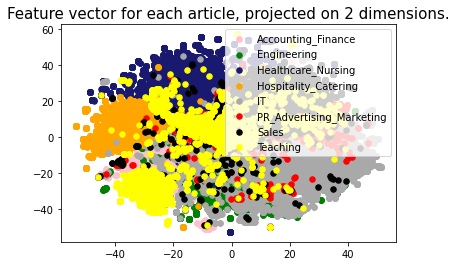

In [5]:
#plot the count vector in 2D
plotTSNE(job_categories, projected_vectors['count_vectors_projected'])

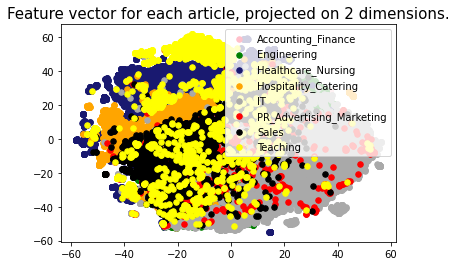

In [6]:
#plot the fasttext unweighted vector in 2D
plotTSNE(job_categories,projected_vectors['fast_text_unweighted_projected'])

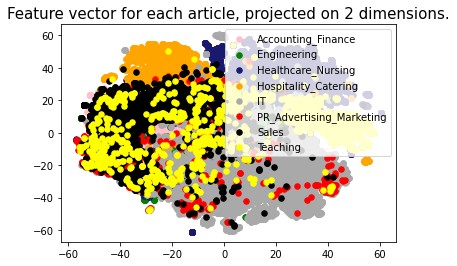

In [7]:
#plot the fasttext weighted vector in 2D
plotTSNE(job_categories,projected_vectors['fast_text_weighted_projected'])

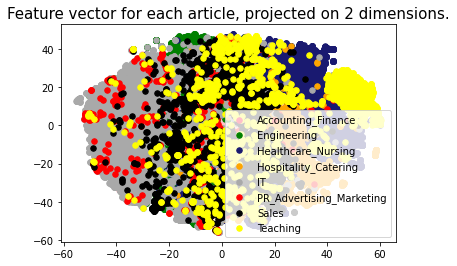

In [8]:
#plot the unweighted google news vector in 2D
plotTSNE(job_categories,projected_vectors['google_news_unweighted_projected'])

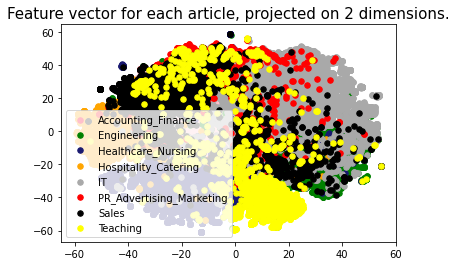

In [9]:
#plot the weighted google news vector in 2D
plotTSNE(job_categories,projected_vectors['google_news_weighted_projected'])

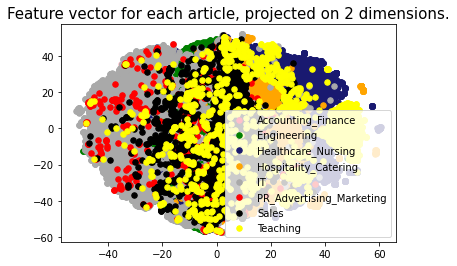

In [10]:
#plot the unweighted glove vector in 2D
plotTSNE(job_categories,projected_vectors['glove_unweighted_projected'])

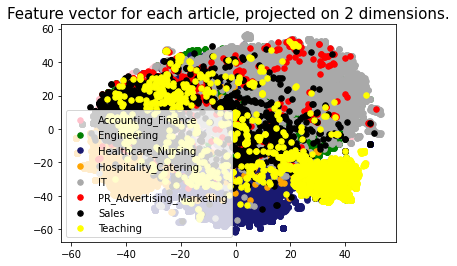

In [11]:
#plot the weighted glove vector in 2D
plotTSNE(job_categories,projected_vectors['glove_weighted_projected'])

In [31]:
#define a function to split, train, and evaluate the model
def model_accuracy(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [32]:
model_accuracy(feature_vectors['google_news_weighted'], job_categories)

0.8672678088367899

In [13]:
# run regression on the projected vectors to save time
for name, vector in projected_vectors.items():
    print(name+':',model_accuracy(vector, job_categories))

count_vectors_projected: 0.6540426810940787
fast_text_unweighted_projected: 0.4919146378118425
fast_text_weighted_projected: 0.7124135858130448
google_news_unweighted_projected: 0.5462578899909829
google_news_weighted_projected: 0.7890592125037571
glove_unweighted_projected: 0.5018935978358882
glove_weighted_projected: 0.7137360985873159


In [14]:
# conduct 5-fold cross validation 
for name, vector in projected_vectors.items():
    scores = cross_val_score(LogisticRegression(max_iter=1000), vector, job_categories, cv=5)
    print(name+':', scores.mean())

count_vectors_projected: 0.6517158190787042
fast_text_unweighted_projected: 0.48682569042782875
fast_text_weighted_projected: 0.7099676337878111
google_news_unweighted_projected: 0.5443199798076079
google_news_weighted_projected: 0.7858570654791494
glove_unweighted_projected: 0.5004059311573765
glove_weighted_projected: 0.7126727410269611


Weighted Google_news_300 performs the best!!!

### Q2 Does more information provide higher accuracy?

#### Q2.1 need to generate feature representations for title first

In [10]:
# read the title
with open('job_ads.txt', 'r') as f:
    job_ads = f.read().splitlines()
    job_titles = [line.lstrip('Title:').strip() for line in job_ads if line.startswith('Title')] # create job titles

In [11]:
# tokenization
tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")
job_titles_tokens = [tokenizer.tokenize(title) for title in job_titles]
job_titles_tokens = [[token.lower() for token in tokens] for tokens in job_titles_tokens]

In [18]:
def tokens_stats (list_name):
    ads_num = len(list_name)
    words_num = len(list(chain.from_iterable(list_name)))
    vocabs_num = len(set(chain.from_iterable(list_name)))
    ads_length = [len(ad) for ad in list_name]
    length_max = max(ads_length)
    length_min = min(ads_length)
    
    print('number of titles:', ads_num)
    print('number of words:', words_num)
    print('number of vocabularies:', vocabs_num)
    print('maximum length of an title:', length_max)
    print('minimum length of an title:', length_min)

In [19]:
tokens_stats(job_titles_tokens)

number of titles: 55449
number of words: 276946
number of vocabularies: 10854
maximum length of an title: 22
minimum length of an title: 0


In [20]:
# remove stopwords
with open('stopwords_en.txt', 'r') as f:
    stopwords = f.read()

stopwords = stopwords.splitlines()
job_titles_tokens = [[token for token in tokens if token not in stopwords] for tokens in job_titles_tokens]

In [21]:
tokens_stats(job_titles_tokens)

number of titles: 55449
number of words: 252719
number of vocabularies: 10621
maximum length of an title: 20
minimum length of an title: 0


In [22]:
# remove word only appear once base on term frequency
words = list(chain.from_iterable(job_titles_tokens))
term_fd = FreqDist(words)
less_frequent_words = set(term_fd.hapaxes())
job_titles_tokens = [[token for token in tokens if token not in less_frequent_words] for tokens in job_titles_tokens]

In [23]:
tokens_stats(job_titles_tokens)

number of titles: 55449
number of words: 247749
number of vocabularies: 5651
maximum length of an title: 18
minimum length of an title: 0


In [24]:
# save the vocabulories
vocabs_title = set(chain.from_iterable(job_titles_tokens))
vocabs_title = sorted(vocabs_title)

vocabs_text_list = [vocabs_title[i] + ':' + str(i) for i in range(len(vocabs_title))]
vocabs_text = '\n'.join(vocabs_text_list)

with open('vocab_title.txt', 'w') as f:
    f.write(vocabs_text)

In [25]:
# read the vocab_title.txt from local
with open('vocab_title.txt', 'r') as f:
    vocabs_text = f.read().splitlines()

vocabs_text2 = [line.split(':') for line in vocabs_text]
vocabs = [word[0] for word in vocabs_text2]
vocab_inds = [word[1] for word in vocabs_text2]
vocab_inds = np.array(vocab_inds)
vocab_dict = {key:value for key,value in zip(vocab_inds, vocabs)}

In [26]:
# generate count vector for job titles
cVectorizer = CountVectorizer(analyzer='word', vocabulary=vocabs, token_pattern=r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")
count_features_title = cVectorizer.fit_transform(job_titles)
count_vectors_title = count_features_title.toarray()

print(count_vectors_title.shape)

(55449, 5651)


In [28]:
FTmodel = FastText(vector_size=200, seed=23, workers=1)

# build the vocabulary
FTmodel.build_vocab(corpus_iterable=job_titles_tokens)

# train the model
FTmodel.train(corpus_iterable=job_titles_tokens, 
              epochs=FTmodel.epochs, 
              total_examples=FTmodel.corpus_count, 
              total_words=FTmodel.corpus_total_words)

(965502, 1238745)

In [29]:
ft_title_wv = FTmodel.wv

In [30]:
# generate TF-IDF features and weights dictionary

tVectorizer = TfidfVectorizer(analyzer='word', vocabulary=vocabs, token_pattern=r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?") # initialize the vectorizer
tfidf_features = tVectorizer.fit_transform(job_titles) # generate tfidf vector
tfidf_vectors = tfidf_features.toarray() # convert to numpy array
conditions2 = tfidf_vectors != 0 # find the weight for each word
tfidf_weights_vectors = [tfidf_vector[condition] for tfidf_vector, condition in zip(tfidf_vectors, conditions2)] # generate weights vectors
tfidf_word_inds = [vocab_inds[condition] for condition in conditions2] # find the indices of words for each weights vector
tfidf_weights_dicts = [{vocab_dict[ind]:weight for ind,weight in zip(tfidf_word_ind, tfidf_weights_vector)} for tfidf_word_ind, tfidf_weights_vector in zip(tfidf_word_inds, tfidf_weights_vectors)] # create dictornaries and make vocabularies as keys weights as values

In [33]:
ft_title_unweighted = gen_docVectors(ft_title_wv, job_titles_tokens)
ft_title_unweighted = [n if type(n)!=int else [0]*200 for n in ft_title_unweighted] # replace int with array
ft_title_unweighted[0][:3]

array([ 0.46688128, -1.2963686 , -1.4607805 ], dtype=float32)

In [34]:
ft_title_weighted = gen_docVectors(ft_title_wv, job_titles_tokens, tfidf_weights_dicts)
ft_title_weighted = [n if type(n)!=int else [0]*200 for n in ft_title_weighted]
ft_title_weighted[0][:3]

array([ 0.20639856, -0.4143483 , -0.36488765], dtype=float32)

In [20]:
# loading the pretrained word2vec model based on googel news
google_news_300_wv = api.load('word2vec-google-news-300')

In [36]:
google_title_unweighted = gen_docVectors(google_news_300_wv, job_titles_tokens)
google_title_unweighted = [n if type(n)!=int else [0]*300 for n in google_title_unweighted]
google_title_unweighted[0][:3]

array([-0.04504395,  0.18286133, -0.3209839 ], dtype=float32)

In [37]:
google_title_weighted = gen_docVectors(google_news_300_wv, job_titles_tokens, tfidf_weights_dicts)
google_title_weighted = [n if type(n)!=int else [0]*300 for n in google_title_weighted]
google_title_weighted[0][:3]

array([-0.02005305,  0.17036748, -0.12362242], dtype=float32)

In [38]:
# load the GloVe word embeding

path_to_glove_file = os.path.join("glove/glove.6B.300d.txt")

glove_wv = {}
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        glove_wv[word] = coefs

print(f"Found {len(glove_wv)} word vectors.")

Found 400000 word vectors.


In [39]:
glove_title_unweighted = gen_docVectors(glove_wv, job_titles_tokens)
glove_title_unweighted = [n if type(n)!=int else [0]*300 for n in glove_title_unweighted]
glove_title_unweighted[0][:3]

array([-0.7430455,  1.312719 ,  0.345074 ], dtype=float32)

In [40]:
glove_title_weighted = gen_docVectors(glove_wv, job_titles_tokens, tfidf_weights_dicts)
glove_title_weighted = [n if type(n)!=int else [0]*300 for n in glove_title_weighted]
glove_title_weighted[0][:3]

array([-0.4311669 ,  0.43534154,  0.27381963], dtype=float32)

In [41]:
np.save('count_vectors_title.npy', count_vectors_title)
np.save('ft_title_unweighted.npy', ft_title_unweighted)
np.save('ft_title_weighted.npy', ft_title_weighted)
np.save('google_title_unweighted.npy', google_title_unweighted)
np.save('google_title_weighted.npy', google_title_weighted)
np.save('glove_title_unweighted.npy', glove_title_unweighted)
np.save('glove_title_weighted.npy', glove_title_weighted)

In [15]:
#load title vectors from local
vector_names_title = [
    'count_vectors_title',
    'ft_title_unweighted',
    'ft_title_weighted',
    'google_title_unweighted',
    'google_title_weighted',
    'glove_title_unweighted',
    'glove_title_weighted'
    ]

feature_vectors = {name:np.load(name+'.npy') for name in vector_names_title}
job_categories = np.load('job_categories.npy')

In [ ]:
# create projected vectors for title and save the results
for name, nparray in feature_vectors.items():
    projected_vetor = TSNE(n_components=2, random_state=23).fit_transform(nparray)
    np.save(name+'_projected.npy', projected_vetor)

In [17]:
# load projected vectors from local
projected_vectors_title = {name+'_projected':np.load(name+'_projected.npy') for name in vector_names_title}

In [18]:
# cross validate the model with projected title vectors only
for name, vector in projected_vectors_title.items():
    scores = cross_val_score(LogisticRegression(max_iter=1000), vector, job_categories, cv=5)
    print(name+':', scores.mean())

count_vectors_title_projected: 0.5102344722806319
ft_title_unweighted_projected: 0.3201500345471076
ft_title_weighted_projected: 0.38563363672608403
google_title_unweighted_projected: 0.6620857491981631
google_title_weighted_projected: 0.6551064105396611
glove_title_unweighted_projected: 0.6509403521845262
glove_title_weighted_projected: 0.6007320669123439


Only title of the job advertisement does not provide higher accuracy!!!

#### Q2.2 only description (already done in Q1)

the performance is higher than title only

#### Q2.3 title + description

In [19]:
# vertically concatenate projected vector for title and projected vector for describtion
title_and_desc = [np.concatenate((value1, value2), axis=1) for value1, value2 in zip(projected_vectors_title.values(), projected_vectors.values())]

In [20]:
# cross validate the model with the concatenated vector
for vector in title_and_desc:
    scores = cross_val_score(LogisticRegression(max_iter=1000), vector, job_categories, cv=5)
    print(scores.mean())

0.6793268075065413
0.5776839362088898
0.7079836694679762
0.7039439680636242
0.7836569778367518
0.6919690078657792
0.7359192681623988


The performance was slightly improved! 

In [16]:
feature_vectors['google_news_weighted']
job_categories

In [34]:
model = LogisticRegression(max_iter=1000, random_state=23)
model.fit(feature_vectors['google_news_weighted'], job_categories)

LogisticRegression(max_iter=1000, random_state=23)

In [36]:
import pickle
with open('google_news_weighted_LR.pkl', 'wb') as file:
     pickle.dump(model, file)

In [37]:
set(job_categories)

{'Accounting_Finance',
 'Engineering',
 'Healthcare_Nursing',
 'Hospitality_Catering',
 'IT',
 'PR_Advertising_Marketing',
 'Sales',
 'Teaching'}

In [38]:
'IT'.lower()

'it'